# Multi Layer Perceptron - KERAS
## ELE606 - Tópicos Especiais em Inteligência Artificial

> Alunos: [Pedro Artur Varela](https://github.com/pedro-varela1) & [Gutembergue Ferreira](https://github.com/GutembergueFerreira)

<img src="https://miro.medium.com/max/1400/1*q_o8pu8aPRGKo2Bq5KvzCQ.png"
    style="width:500px; float: right; margin: 0 40px 40px 40px;"></img>
  
![divider](https://webstockreview.net/images/divider-clipart-design-line-5.png)

Nesta atividade, utilizaremos uma estrutura multitarefa em cascata profunda usando diferentes recursos de “submodelos” para cada um aumentar seus pontos fortes correlacionados, algoritmo impliementado na biblioteca MTCNN.

MTCNN é uma biblioteca python (pip) escrita pelo usuário ipacz do Github, que implementa o artigo Zhang, Kaipeng et al. “Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks.” IEEE Signal Processing Letters 23.10 (2016): 1499–1503. Crossref. Web.

In [1]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.7 MB/s eta 0:00:00


Primeiramente, vamos importar as dependência utilizada, incluindo o modelo acima descrito, bibliotecas de visualização e de manipulação de dados, além de checagem de progressos.

In [2]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image

import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
DIRECTORY = "../input/yale-face-database/"

# Exploratory Data Analysis
O Yale Face Database é composto por 165 imagens em grayscale de 15 pessoas. São 11 imagens por pessoa com expressões diferentes.

(243, 320, 3)


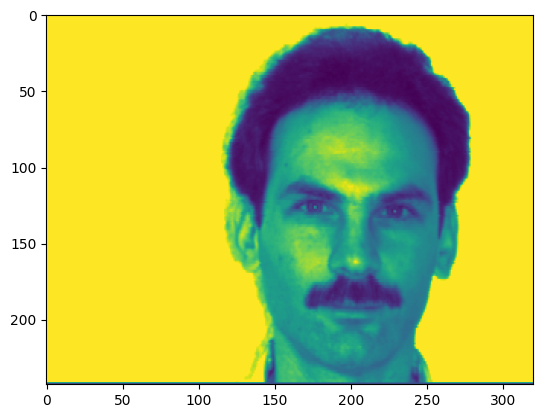

In [4]:
filename = "../input/yale-face-database/subject02.centerlight"
pixels = plt.imread(filename)

rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)
plt.imshow(pixels)
plt.show()

Em cada uma das imagens, o rosto está posicionado em uma região diferente. A primeira tarefa é normalizar todas as posições das faces para que possam ser alimentadas de forma confiável em um classificador. Existem poucas técnicas para conseguir isso. Haar Cascades fornece um método simples e rápido para detectar rostos, mas pode não ser confiável. Eles são ideais para detecção em tempo real. A identificação facial pode permitir-se gastar mais tempo processando a imagem. Portanto usaremos MTCNN que é um algoritmo de detecção de rosto usando uma CNN, que atinge uma precisão muito maior do que outras técnicas.

In [5]:
# Criando o detector e detectando
detector = MTCNN()
results = detector.detect_faces(rgb_pixels)
results

1/1 [==============================] - 0s 163ms/step


[{'box': [138, 63, 117, 163],
  'confidence': 0.9926654696464539,
  'keypoints': {'left_eye': (174, 128),
   'right_eye': (232, 130),
   'nose': (205, 164),
   'mouth_left': (178, 191),
   'mouth_right': (226, 192)}}]

Com a detecção dos rostos feita, vamos desenhar a imagem completa com o rosto detectado com _red boxes_.

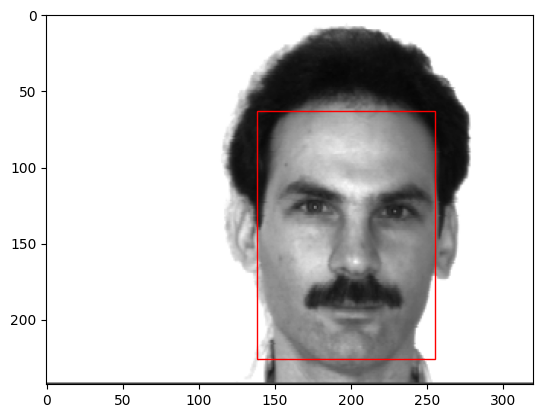

In [6]:
def draw_image_with_boxes(data, result_list):
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()

draw_image_with_boxes(rgb_pixels, results)

A próxima etapa é extrair e normalizar os pixels da face para que possam ser usados de forma confiável para classificação.

1/1 [==============================] - 0s 158ms/step


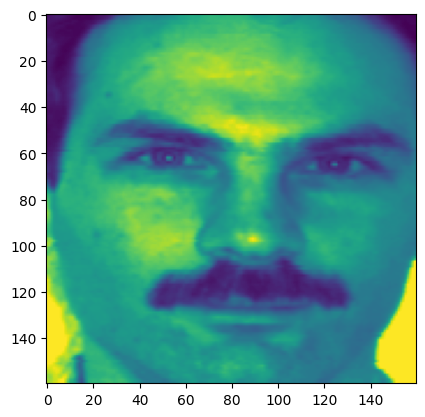

In [7]:
def extract_face_from_file(filename, required_size=(160, 160)):
    # carregar imagens
    image = Image.open(filename)
    
    return extract_face(image, required_size)

def extract_face(image, required_size=(160, 160)):
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    
    return gray_face


# Detector
detector = MTCNN()

# Load e Extract
face_pixels = extract_face_from_file("../input/yale-face-database/subject02.centerlight")

plt.imshow(face_pixels)

# Construindo o dataset
Precisamos extrair os rostos de todas as imagens para que possamos criar nosso conjunto de dados para treinamento/teste.

Vamos listar os diretórios com os dados.

In [8]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)

Vamos extrair os rostos e mostrar um para cada indivíduo.

  0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1/16 [00:00<00:11,  1.27it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▎        | 2/16 [00:01<00:11,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 4/16 [00:03<00:09,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 5/16 [00:03<00:08,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6/16 [00:04<00:07,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7/16 [00:05<00:07,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 8/16 [00:06<00:06,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 9/16 [00:07<00:05,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▎   | 10/16 [00:08<00:05,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 11/16 [00:09<00:04,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 12/16 [00:09<00:03,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 13/16 [00:10<00:02,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 14/16 [00:11<00:01,  1.25it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 15/16 [00:12<00:00,  1.22it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


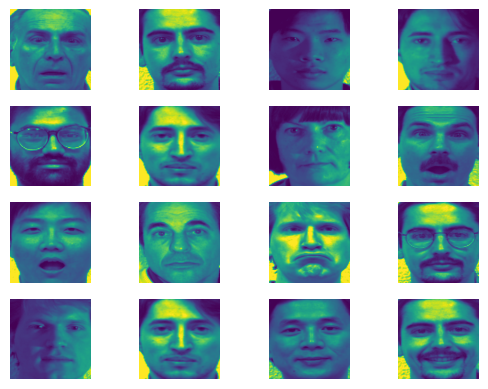

In [9]:
i = 1
faces = list()
for filename in tqdm(list_files(DIRECTORY, "subject")[0:16]):
    # path
    path = DIRECTORY + filename
    # get face
    face = extract_face_from_file(path)
    # plot
    plt.subplot(4, 4, i)
    plt.axis('off')
    plt.imshow(face)
    faces.append(face)
    i += 1
plt.show()

## Setup dos Dados de Teste e Treinamento

Vamos criar um dataframe com informações dos dados, como o indivíduo e categoria.

In [10]:
# list filenames
filenames = pd.DataFrame(list_files(DIRECTORY, "subject"))

# generate split 
df = filenames[0].str.split(".", expand=True)
df["filename"] = filenames

# # tidy columns
df = df.rename(columns = {0:"subject", 1:"category"})
df['subject'] = df.subject.str.replace('subject' , '')
df.apply(pd.to_numeric, errors='coerce').dropna()
df['subject'] = pd.to_numeric(df["subject"])

display(df.head())
display(df.tail())
display(df['subject'].unique())

,subject,category,filename
0,5,surprised,subject05.surprised
1,9,normal,subject09.normal
2,4,rightlight,subject04.rightlight
3,3,leftlight,subject03.leftlight
4,7,glasses,subject07.glasses


,subject,category,filename
160,10,noglasses,subject10.noglasses
161,6,centerlight,subject06.centerlight
162,14,centerlight,subject14.centerlight
163,12,normal,subject12.normal
164,8,noglasses,subject08.noglasses


array([ 5,  9,  4,  3,  7, 11,  2, 14, 12,  1,  6, 15, 13,  8, 10])

### Split Teste e Treino

Há um número limitado de amostras por classe, embora seja necessário um número adequado de classes para avaliar os modelos de forma adequada. Decidi por uma divisão do trem de teste de mais ou menos 70/30 (suficiente para 3 imagens de teste).

In [11]:
PER_CLASS = 8 # 11 images (3 test & 8 train)
NO_CLASSES = 15
DS_SIZE = df["subject"].count()
TEST_SIZE = 1 - (PER_CLASS * NO_CLASSES / DS_SIZE)

y = df['subject']
X = df.drop('subject',axis=1)

X_train_info, X_test_info, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=45, stratify=y)

y_train = y_train.tolist()
y_test = y_test.tolist()

### Extraindo as Faces
Vamos extrair as faces com o detector anteriormente mencionado.

In [12]:
detector = MTCNN()

def load_dataset(dataset):
    faces = list()
    for filename in tqdm(dataset["filename"]):
        path = DIRECTORY + filename
        # Obter Face
        face = extract_face_from_file(path)
        faces.append(face)
    return np.asarray(faces)

O carregamento pode demorar.

In [13]:
X_test = load_dataset(X_test_info)
X_train = load_dataset(X_train_info)

print(X_test.shape)
print(X_train.shape)

  0%|          | 0/45 [00:00<?, ?it/s]

1/1 [==============================] - 0s 176ms/step


  2%|▏         | 1/45 [00:01<00:56,  1.29s/it]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 2/45 [00:02<00:42,  1.00it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 3/45 [00:02<00:37,  1.11it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 4/45 [00:03<00:34,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 5/45 [00:04<00:32,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 6/45 [00:05<00:36,  1.07it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 7/45 [00:06<00:34,  1.10it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 8/45 [00:07<00:32,  1.14it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 9/45 [00:08<00:30,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 10/45 [00:08<00:29,  1.20it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 11/45 [00:09<00:27,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 12/45 [00:10<00:27,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 13/45 [00:11<00:25,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 14/45 [00:11<00:24,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 15/45 [00:12<00:23,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 16/45 [00:13<00:22,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 17/45 [00:14<00:22,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 18/45 [00:15<00:21,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 19/45 [00:15<00:20,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 20/45 [00:16<00:19,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 21/45 [00:17<00:18,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 22/45 [00:18<00:17,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 23/45 [00:18<00:16,  1.31it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 24/45 [00:19<00:15,  1.33it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 25/45 [00:20<00:15,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 26/45 [00:21<00:14,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 27/45 [00:22<00:13,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 28/45 [00:22<00:13,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 29/45 [00:23<00:12,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 30/45 [00:24<00:11,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 31/45 [00:25<00:11,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 32/45 [00:26<00:10,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 33/45 [00:26<00:09,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 34/45 [00:27<00:08,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 35/45 [00:28<00:07,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 36/45 [00:29<00:06,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 37/45 [00:29<00:06,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 38/45 [00:30<00:05,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 39/45 [00:31<00:04,  1.30it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 40/45 [00:32<00:03,  1.28it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 41/45 [00:32<00:03,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 42/45 [00:33<00:02,  1.29it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 43/45 [00:34<00:01,  1.31it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 44/45 [00:35<00:00,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 1/120 [00:00<01:26,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 2/120 [00:01<01:31,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▎         | 3/120 [00:02<01:31,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 4/120 [00:03<01:30,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 5/120 [00:03<01:30,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 6/120 [00:04<01:29,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 7/120 [00:05<01:28,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 8/120 [00:06<01:27,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 9/120 [00:07<01:28,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 10/120 [00:07<01:26,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 11/120 [00:08<01:24,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 12/120 [00:09<01:24,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 13/120 [00:10<01:23,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 14/120 [00:10<01:24,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 15/120 [00:11<01:23,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 16/120 [00:12<01:22,  1.26it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 17/120 [00:13<01:21,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 18/120 [00:14<01:21,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 19/120 [00:14<01:20,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 20/120 [00:15<01:18,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 21/120 [00:16<01:19,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 22/120 [00:17<01:19,  1.24it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 23/120 [00:18<01:20,  1.21it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 24/120 [00:19<01:22,  1.16it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 25/120 [00:20<01:22,  1.15it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 26/120 [00:20<01:20,  1.16it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▎       | 27/120 [00:21<01:18,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 28/120 [00:22<01:15,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 29/120 [00:23<01:15,  1.21it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 30/120 [00:24<01:14,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 31/120 [00:24<01:12,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 32/120 [00:25<01:11,  1.22it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 33/120 [00:26<01:10,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 34/120 [00:27<01:08,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 35/120 [00:28<01:06,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 36/120 [00:28<01:06,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 37/120 [00:29<01:07,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 38/120 [00:30<01:07,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 39/120 [00:31<01:05,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 40/120 [00:32<01:05,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 41/120 [00:33<01:03,  1.24it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 42/120 [00:34<01:12,  1.07it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 43/120 [00:35<01:10,  1.09it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 44/120 [00:36<01:09,  1.09it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 45/120 [00:36<01:09,  1.08it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 46/120 [00:37<01:08,  1.08it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 47/120 [00:38<01:05,  1.12it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 48/120 [00:39<01:02,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 49/120 [00:40<01:00,  1.18it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 50/120 [00:41<00:57,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 51/120 [00:41<00:55,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 52/120 [00:42<00:53,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 53/120 [00:43<00:51,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 54/120 [00:44<00:50,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 55/120 [00:44<00:48,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 56/120 [00:45<00:48,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 57/120 [00:46<00:47,  1.33it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 58/120 [00:47<00:47,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 59/120 [00:47<00:46,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 60/120 [00:48<00:45,  1.32it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 61/120 [00:49<00:45,  1.29it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 62/120 [00:50<00:46,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 63/120 [00:51<00:45,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 64/120 [00:51<00:44,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 65/120 [00:52<00:43,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 66/120 [00:53<00:42,  1.27it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 67/120 [00:54<00:42,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 68/120 [00:55<00:41,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 69/120 [00:55<00:40,  1.25it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 70/120 [00:56<00:39,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 71/120 [00:57<00:39,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 72/120 [00:58<00:38,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 73/120 [00:59<00:37,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 74/120 [00:59<00:37,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 75/120 [01:00<00:35,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 76/120 [01:01<00:33,  1.30it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 77/120 [01:02<00:32,  1.30it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 78/120 [01:02<00:32,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 79/120 [01:03<00:32,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 80/120 [01:04<00:31,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 81/120 [01:05<00:30,  1.26it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 82/120 [01:06<00:29,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 83/120 [01:06<00:29,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 84/120 [01:07<00:29,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 85/120 [01:08<00:28,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 86/120 [01:09<00:27,  1.23it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▎  | 87/120 [01:10<00:26,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 88/120 [01:11<00:25,  1.23it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 89/120 [01:11<00:25,  1.20it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 90/120 [01:12<00:24,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 91/120 [01:13<00:23,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 92/120 [01:14<00:22,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 93/120 [01:15<00:21,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 94/120 [01:15<00:20,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 95/120 [01:16<00:19,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 96/120 [01:17<00:18,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 97/120 [01:18<00:17,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 98/120 [01:19<00:17,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▎ | 99/120 [01:19<00:16,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 100/120 [01:20<00:15,  1.28it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 101/120 [01:21<00:14,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 102/120 [01:22<00:14,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 103/120 [01:22<00:13,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 104/120 [01:23<00:12,  1.31it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 105/120 [01:24<00:11,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 106/120 [01:25<00:10,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 107/120 [01:26<00:10,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 108/120 [01:26<00:09,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 109/120 [01:27<00:08,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 110/120 [01:28<00:07,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 111/120 [01:29<00:07,  1.28it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 112/120 [01:29<00:06,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 113/120 [01:30<00:05,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 114/120 [01:31<00:04,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 115/120 [01:32<00:03,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 116/120 [01:33<00:03,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 117/120 [01:33<00:02,  1.29it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 118/120 [01:34<00:01,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 119/120 [01:35<00:00,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 120/120 [01:36<00:00,  1.25it/s]

(45, 160, 160)
(120, 160, 160)


## Treinando uma MLP
MLP significa "Multi-Layer Perceptron" e é um tipo fundamental de rede neural artificial composta por múltiplas camadas de neurônios, incluindo uma camada de entrada, uma ou mais camadas ocultas e uma camada de saída. Cada neurônio em uma camada está conectado a todos os neurônios da camada seguinte, utilizando pesos para transmitir informações. A MLP é conhecida por sua capacidade de aprendizado não linear e é amplamente utilizada em tarefas de classificação, regressão e reconhecimento de padrões, sendo uma base importante para muitas outras arquiteturas de redes neurais profundas.

Vamos ajustar os parâmEtros que podem ser alterados da rede neural.

In [14]:
# Parametros

TRAINING_DATA_DIRECTORY = "data/train"
TESTING_DATA_DIRECTORY = "data/test"
NUM_CLASSES = 15
EPOCHS = 25
BATCH_SIZE = 20
NUMBER_OF_TRAINING_IMAGES = 120
NUMBER_OF_TESTING_IMAGES = 45
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160

### Salvar o dataset no disco e Carregar no Keras

Keras incorporou recursos para carregar dados do disco, portanto, salvaremos o conjunto de dados.

Keras é uma biblioteca de alto nível para aprendizado de máquina e redes neurais em Python. Ela oferece uma interface simples e intuitiva que facilita a construção, treinamento e avaliação de modelos de redes neurais. Projetada para ser modular e extensível, a Keras permite a criação rápida de modelos complexos, fornecendo suporte para diversas arquiteturas de redes neurais, incluindo redes convolucionais, recorrentes e modelos combinados. Além disso, a Keras oferece compatibilidade com diferentes backends, como TensorFlow, Theano e CNTK, o que proporciona flexibilidade aos usuários na escolha da plataforma para executar suas redes neurais. Essa biblioteca é amplamente utilizada na comunidade de aprendizado de máquina devido à sua facilidade de uso, documentação abrangente e suporte para experimentação rápida e desenvolvimento de modelos de inteligência artificial.

In [15]:
import os 

def save_keras_dataset(setname, dataset, labels, per_class):
    # Combinando Labels e Imagens
    data = sorted(list(zip(labels, dataset)), key=lambda x: x[0])

    # Salvando
    j = 0
    for label, gray_img in tqdm(data):
        j = (j% per_class) + 1
        # Diretorio
        directory = f"data/{setname}/class_{label}/"
        if not os.path.exists(directory):
                os.makedirs(directory)
        cv2.imwrite(f"{directory}class_{label}_{j}.png",gray_img)

Vamos limpar o diretório se já existir (caso a célula seja _run_ mais de uma vez) e depois salvar como um dataset do Keras.

In [16]:
# Limpando diretorio
import shutil
shutil.rmtree(r'data', ignore_errors=True)

# Salvando dataset
save_keras_dataset("test", X_test, y_test, 3)
save_keras_dataset("train", X_train, y_train, 8)

100%|██████████| 120/120 [00:00<00:00, 1332.00it/s]


### Configure Dados

Keras inclui um ImageDataGenerator que pode dar uma nova escala aos dados

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def data_generator():
    return ImageDataGenerator(
        rescale=1./255,
    )

Vamos aplicar o _reshape_ e a adição do ruído ao dataset.

In [18]:
# Setup dos Data Generators
training_generator = data_generator().flow_from_directory(
    TRAINING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)

testing_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False # IMPORTANTE: to ensure classes line up with batches
)

Found 120 images belonging to 15 classes.
Found 45 images belonging to 15 classes.
Found 45 images belonging to 15 classes.


Vamos ver algumas _sample_images_.

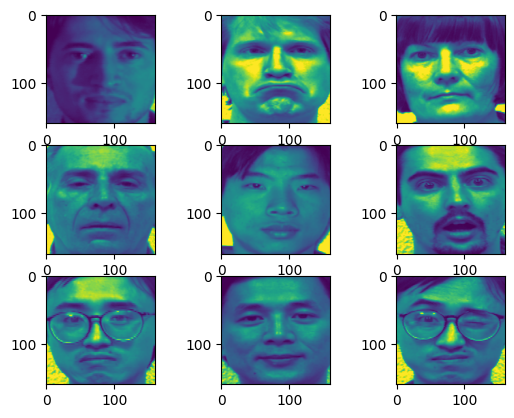

In [19]:
sample_images = testing_generator.next()[0]

f, xyarr = plt.subplots(3,3)
xyarr[0,0].imshow(sample_images[0])
xyarr[0,1].imshow(sample_images[1])
xyarr[0,2].imshow(sample_images[2])
xyarr[1,0].imshow(sample_images[3])
xyarr[1,1].imshow(sample_images[4])
xyarr[1,2].imshow(sample_images[5])
xyarr[2,0].imshow(sample_images[6])
xyarr[2,1].imshow(sample_images[7])
xyarr[2,2].imshow(sample_images[8])
plt.show()

Vamos modelar a arquitetura da MLP.

In [20]:
from tensorflow.keras import models
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Definindo um modelo sequencial do Keras
model = models.Sequential()

# Flatten
model.add(Flatten(input_shape=(IMAGE_WIDTH * IMAGE_HEIGHT,)))  # A entrada é achatada para um vetor unidimensional

# Primeira camada escondida
model.add(Dense(512, activation='relu'))

# Segunda camada escondida
model.add(Dense(256, activation='relu'))

# Camada de saída softmax
model.add(Dense(NUM_CLASSES, activation='softmax'))

Podemos obter um sumário do modelo.

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 25600)             0         
                                                                 
 dense_21 (Dense)            (None, 512)               13107712  
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dense_23 (Dense)            (None, 15)                3855      
                                                                 
Total params: 13242895 (50.52 MB)
Trainable params: 13242895 (50.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Antes de treinar, vamos vetorizar a imagem para a entrada na rede neural:

In [22]:
# Carregar e achatar as imagens para o modelo
def load_and_flatten(generator):
    images, labels = generator.next()
    images = images.reshape(images.shape[0], -1)
    return images, labels

Vamos TREINAR!

In [23]:
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

history = model.fit(
    *load_and_flatten(training_generator),
    steps_per_epoch=(NUMBER_OF_TRAINING_IMAGES//BATCH_SIZE ),
    epochs=EPOCHS,
    validation_data=load_and_flatten(testing_generator),
    shuffle=True,
    validation_steps=(NUMBER_OF_TESTING_IMAGES//BATCH_SIZE),
)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


6/6 [==============================] - 2s 195ms/step - loss: 21.2201 - accuracy: 0.0417 - val_loss: 10.0679 - val_accuracy: 0.0000e+00
Epoch 2/25
6/6 [==============================] - 1s 172ms/step - loss: 7.4332 - accuracy: 0.2917 - val_loss: 11.1042 - val_accuracy: 0.0769
Epoch 3/25
6/6 [==============================] - 1s 143ms/step - loss: 5.9542 - accuracy: 0.3750 - val_loss: 5.2105 - val_accuracy: 0.1538
Epoch 4/25
6/6 [==============================] - 1s 139ms/step - loss: 3.7179 - accuracy: 0.4167 - val_loss: 5.2768 - val_accuracy: 0.3077
Epoch 5/25
6/6 [==============================] - 1s 146ms/step - loss: 1.6496 - accuracy: 0.6667 - val_loss: 4.3019 - val_accuracy: 0.2308
Epoch 6/25
6/6 [==============================] - 1s 138ms/step - loss: 0.8866 - accuracy: 0.6667 - val_loss: 4.6064 - val_accuracy: 0.3846
Epoch 7/25
6/6 [==============================] - 1s 138ms/step - loss: 0.4811 - accuracy: 0.7917 - val_loss: 4.8757 - val_accuracy: 0.3846
Epoch 8/25
6/6 [========

### Validação do Modelo MLP

Após o treinamento, podemos avaliar o modelo para testar sua precisão.


Gráfico de Acurácias

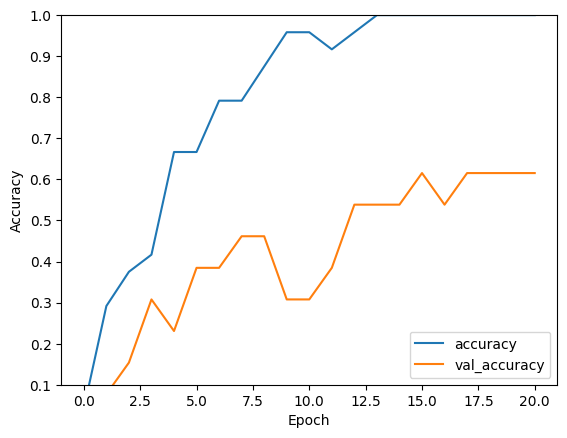

In [24]:
plot_folder = "plot"
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

Gráfico de Loss

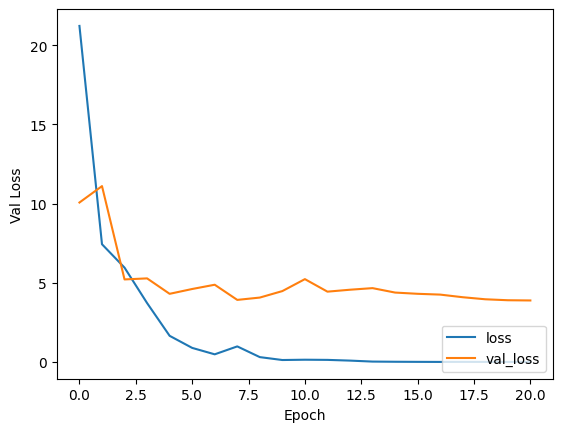

In [25]:
plot_folder = "plot"
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend(loc='lower right')

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(validation_generator.classes, y_pred))

2/2 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.30      1.00      0.46         3
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       1.00      0.67      0.80         3
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         3
           8       1.00      0.67      0.80         3
           9       0.75      1.00      0.86         3
          10       0.60      1.00      0.75         3
          11       0.00      0.00      0.00         3
          12       1.00      1.00      1.00         3
          13       0.75      1.00      0.86         3
          14       0.50      1.00      0.67         3

    accuracy                           0.62        45
   macro avg       0.56     

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vamos analizar a matriz de confusão.

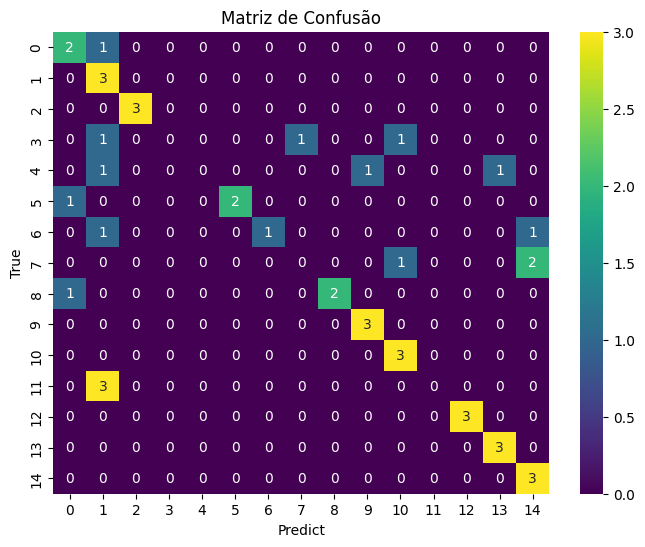

In [27]:
import seaborn as sns

conf_matrix = confusion_matrix(validation_generator.classes, y_pred)

# Plotar a matriz de confusão com Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Matriz de Confusão')
plt.xlabel('Predict')
plt.ylabel('True')
plt.show()

Portanto, vemos que uma rede neural multi layer perceptron é pior que a rede neural com camadas convolucionais. Vemos que houve um overffiting nos dados de treinamento, ou seja, a rede neural não foi capaz de generalizar.